In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from numba import njit
from numpy.random import normal
from statistics import geometric_mean

In [ ]:
@njit
def euler_Method(S0, interest_rate, delta_t, N, volatality):
    """
    Euler method for stock price simulation 

    Args:
        S0 : Stock price at time 0
        interest_rate : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        volatality : Volatality of the stock

    Returns:
        stock_prices : Stock prices for N time steps
    """
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = normal()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
        
    return stock_prices

In [ ]:
@njit
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [ ]:
@njit
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type = "call" , seed_value = 2):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [ ]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    """
    Function to calculate the price of the option using Black Scholes model

    Args:
        current_stock_price : Current stock price
        strike_price : Strike price
        current_time : Current time
        maturity_time : Maturity time
        interest_rate :  Risk free interest rate
        volatality : Volatality of the stock

    Returns:
        Option_price : Price of the option at current time
        delta : Delta value of the option
    """
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
    
    return option_price, - norm.cdf(-d1) 

In [ ]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
# Option price from black scholes
option_BS, _ = blackScholes(S0, K, 0, T, r, sigma)

In [ ]:
m = np.arange(100, 20000, 100)
option_values = []
std_errors = []
lower = []
upper = []
# Monte Carlo Simulation for option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put", 0)
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)

In [ ]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper,color = "lightblue")
plt.plot(m, lower, color = "lightblue")
plt.fill_between(m, upper, lower, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=250)
plt.plot(m, std_errors)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Number of Trials")
plt.show()

In [ ]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 30000, 100)
# Monte Carlo Simulation for option pricing for volatality = 0.5
sigma = 0.5
option_values2= []
std_errors2 = []
lower2 = []
upper2 = []
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values2.append(option_value)
    std_errors2.append(sd_error)
    lower2.append(ml)
    upper2.append(mu)

In [ ]:
# Option price from black scholes for volatality = 0.5
option_BS2, _ = blackScholes(S0, K, 0, T, r, sigma)

In [ ]:
# Plot for option pricing for volatality = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, option_values2, label='Option value')
plt.axhline(option_BS2, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper2, color = "lightblue")
plt.plot(m, lower2, color = "lightblue")
plt.fill_between(m, upper2, lower2, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

In [ ]:
# Plot for standard error for volatality = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, std_errors2)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.show()

##### Varying strike Price

In [ ]:
# Parameters
K = np.arange(80, 120, 0.5)
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 15000
N = int(T/delta_t)


option_values3 = []
std_errors3 = []
lower3 = []
upper3 = []

for k in tqdm(K):
    option_value, sd_error , ml, mu  = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    option_values3.append(option_value)
    std_errors3.append(sd_error)
    lower3.append(ml)
    upper3.append(mu)

In [ ]:
##Plotting the option values
plt.plot(K, option_values3)
plt.plot(K, upper3)
plt.plot(K, lower3)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.fill_between(K, upper3, lower3, color="k", alpha=0.1)

In [ ]:
plt.figure(dpi=250)
plt.plot(K, std_errors3)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.show()

### Varying volatality in Monte Carlo 

In [ ]:
# Parameters
vols = np.arange(0.1, 1.0, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 15000
N = int(T/delta_t)
CI_lower_vol = []
CI_upper_vol = []
std_errors_vol = []

option_values = []
for vol in tqdm(vols):
    option_value, std_error, ml, mu = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    option_values.append(option_value)
    std_errors_vol.append(std_error)
    CI_lower_vol.append(ml)
    CI_upper_vol.append(mu)

In [ ]:
##Plotting the option values
plt.figure(dpi=250)
plt.plot(vols, option_values, label='Option value')
plt.plot(vols, CI_upper_vol, color = "lightblue", label = "Confidence Interval")
plt.plot(vols, CI_lower_vol, color = "lightblue")
plt.fill_between(vols, CI_upper_vol, CI_lower_vol, color="k", alpha=0.1)
plt.xlabel("Volatality")
plt.ylabel("Option Value")
plt.legend()

In [ ]:
plt.figure(dpi=250)
plt.plot(vols, std_errors_vol)
plt.xlabel("Volatality")
plt.ylabel("Standard Error")    
plt.show()  

### Part I - B

##### Milstein - Heston Model

In [ ]:
## Milstein Variance Process
@njit
def m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, Barrirer, K):
    prev_v = 0
    prev_S = S0
    Zv = np.random.normal()
    Z2 = np.random.normal()
    Zs = corr * Zv + np.sqrt(1 - corr**2) * Z2
    #variance = [prev_v]
    #assetPrice = [prev_S]
    
    for _ in np.arange(dt, 1., dt):
        vplus = max(0, prev_v)
        next_v = prev_v + k * (theta - vplus) * dt + vol_of_vol * np.sqrt(vplus * dt) * Zv + vol_of_vol ** 2 * dt * (Zv**2-1)/4
        next_S = prev_S + r * prev_S * dt + np.sqrt(vplus * dt) * Zs * prev_S + vplus * prev_S* dt * (Zs ** 2 - 1)/2
        prev_v = next_v
        if next_S >= Barrirer:
            return 0
        #variance.append(prev_v)
        #assetPrice.append(next_S)
    payOff = max(0, next_S - K)
    
    return payOff
        

In [ ]:
@njit
def approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K):
    
    np.random.seed(2)
    payoffs_MH = np.zeros(10000)
    for i in range(10000):
        payoff = m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
        payoffs_MH[i] = payoff 
    option_approx = np.mean(payoffs_MH) * np.exp(-r* T)
    
    return option_approx


## Analysis

In [ ]:
#### Initial Parameters
r = 0.05
theta = 0.04
k = 2
vol_of_vol = 0.1
corr = - 0.7
dt = 1/252
S0 =100
T = 1.0
K = 100
Barrier = np.arange(90, 120, 0.5)

#### Variation in Barrier

In [ ]:
## Approximating the option price using Milstein Variance Process with Varying Barrier
option_prices_B = []
for B in tqdm(Barrier):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_B.append(option_approx)   

In [ ]:
# Plotting the option prices for different barriers with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(Barrier, option_prices_B)
plt.xlabel("Barrier")
plt.ylabel("Option Value")


#### Variation in Correlation

In [ ]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
vol_of_vol = 0.1    # volatility of volatility
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
corr = np.arange(-1, 1.1, 0.1)

In [ ]:
option_prices_corr = []
for Correlation in tqdm(corr):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, Correlation, r, S0, B, K)
    option_prices_corr.append(option_approx)

In [ ]:
# Plotting the option prices for different correlation with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(corr, option_prices_corr)
plt.xlabel("Correlation")
plt.ylabel("Option Value")
plt.show()

#### Variation in Vol of Vol

In [ ]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
vol_of_vol = np.arange(0, 1, 0.025)

In [ ]:
# Approximating the option price using Milstein Variance Process with Varying Volatility of Volatility
option_prices_vol_of_vol = []
for volOfvol in tqdm(vol_of_vol):
    option_approx = approximateOptionPrice_MH(k, dt, volOfvol, theta, corr, r, S0, B, K)
    option_prices_vol_of_vol.append(option_approx)

In [ ]:
# Plotting the option prices for different volatility of volatility with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(vol_of_vol, option_prices_vol_of_vol)
plt.xlabel("Volatility of Volatility")
plt.ylabel("Option Value")
plt.show()

##### Variation in Mean Reversion

In [ ]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
vol_of_vol = 0.1      # volatility of volatility
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
# Mean Reversion
k = np.arange(0, 10, 0.05)

In [ ]:
# Approximating the option price using Milstein Variance Process with Varying Mean Reversion
option_prices_k = []
for k_ in tqdm(k):
    option_approx = approximateOptionPrice_MH(k_, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_k.append(option_approx)

In [ ]:
# Plotting the option prices for different mean reversion with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(k, option_prices_k)
plt.xlabel("Mean Reversion")
plt.ylabel("Option Value")
plt.show()

## Estimation of Sensitivities in MC

#### Bump and Revalue Method for Delta

In [ ]:
_, delta_B = blackScholes(100, 99, 0, 1, 0.06, 0.2)

In [ ]:
delta_diff = []
delta_same = []
delta_B = []
for vol in tqdm(np.arange(0.01, 1.0, 0.01)):
    non_bumped_diff ,_,  _ , _ =  priceOption(95, 0.06 , delta_t, N, vol, 99, 10000,"put", 1)
    bumped_diff ,_,  _ , _  =  priceOption(100, 0.06 , delta_t, N, vol, 99, 10000,"put", 2)
    delta_DiffSeed = (bumped_diff - non_bumped_diff)/(100 - 95)
    non_bumped ,_ ,  _ , _ =  priceOption(95, 0.06 , delta_t, N, vol, 99, 10000,"put", 1)
    bumped ,_ , _ , _  =  priceOption(100, 0.06 , delta_t, N, vol, 99, 10000,"put", 1)
    delta_SameSeed = (bumped - non_bumped)/(100 - 95)
    delta_BlackScholes = blackScholes(100, 99, 0, 1, 0.06, vol)[1]
    delta_B.append(delta_BlackScholes)
    delta_same.append(delta_SameSeed)
    delta_diff.append(delta_DiffSeed)
    

In [ ]:
plt.figure(dpi=250)
plt.plot(np.arange(0.01, 1.0, 0.01), delta_diff, label="Different Seed")
plt.plot(np.arange(0.01, 1.0, 0.01), delta_same, label="Same Seed")
plt.plot(np.arange(0.01, 1.0, 0.01), delta_B, label="Black Scholes")
plt.legend()
plt.xlabel("Volatality")
plt.ylabel("Delta")


#### Digital Option

In [ ]:
def OptionPrice_Digital(S0, r, delta_t, N, sigma, K, M, option_type = "call" , seed_value = 2):
    """
    Function to price the option using Monte Carlo simulation for Digital Option

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type (str, optional): Type of Option. Defaults to "call".
        seed_value (int, optional): Seed value for random number generation.Defaults to 2.

    Returns:
        price_option : Price of the option at current time
        std_error : Standard error
        ml : Lower bound of the confidence interval
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = 1 * (stock_price_N > K)
        else:
            pay_off = 1 * (stock_price_N < K)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [ ]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 20000, 100)

option_values_digi = []
std_errors_digi = []
lower_digi = []
upper_digi = []
# Monte Carlo Simulation for Digital Option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu = OptionPrice_Digital(S0, r, delta_t, N, sigma, K, M,"put")
    option_values_digi.append(option_value)
    std_errors_digi.append(sd_error)
    lower_digi.append(ml)
    upper_digi.append(mu)

In [ ]:
# Plot for Digital Option pricing using Monte Carlo
plt.figure(dpi = 250)
plt.plot(m, option_values_digi)
plt.plot(m, upper_digi, "lightblue", linestyle = "--")
plt.plot(m, lower_digi, "lightblue", linestyle = "--")
plt.fill_between(m,upper_digi, lower_digi, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.grid(True)
plt.show()

#### Delta for digital option Using Bump and Revalue method

In [ ]:
bumped_digi ,_ ,  _ , _  =  OptionPrice_Digital(101, 0.06 , delta_t, N, 0.2, 99, 10000, "call", 1)
non_bumped_digi ,_ ,  _ , _ =  OptionPrice_Digital(100, 0.06 , delta_t, N, 0.2, 99, 10000, "call", 1)
delta_digi = (bumped_digi - non_bumped_digi)/(101 - 100)
print("Delta for Digital Option: ", delta_digi)

In [ ]:
def OptionPrice_Digital_Pathwise(S0, r, delta_t, N, sigma, K, M, option_type = "call" , epsilon=0.01, seed_value = 0):
    """
    Function to price the option using Monte Carlo simulation for Digital Option with smooth payoff

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type (str, optional): Type of Option. Defaults to "call".
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        price_option : Price of the option at current time
        std_error : Standard error
        ml : Lower bound of the confidence interval
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed_value)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = 1/(1 +  np.exp(-(stock_price_N - K)/epsilon))
        else:
            pay_off = 1/(1 +  np.exp(-(K - stock_price_N)/epsilon))
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [ ]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 20000, 50)

# Monte Carlo Simulation for Digital Option pricing with smooth payoff  
option_values_digi_smooth = []
std_errors_digi_smooth = []
lower_digi_smooth = []
upper_digi_smooth = []
for M in tqdm(m):
    option_value, sd_error , ml, mu   = OptionPrice_Digital_Pathwise(S0, r, delta_t, N, sigma, K, M,"put")
    option_values_digi_smooth.append(option_value)
    std_errors_digi_smooth.append(sd_error)
    lower_digi_smooth.append(ml)
    upper_digi_smooth.append(mu)

In [ ]:
# Plot for Digital Option pricing using Monte Carlo with smooth payoff
plt.figure(dpi = 250)
plt.plot(m, option_values_digi_smooth)
plt.plot(m, upper_digi_smooth, "lightblue", linestyle = "--")
plt.plot(m, lower_digi_smooth, "lightblue", linestyle = "--")
plt.fill_between(m,upper_digi_smooth, lower_digi_smooth, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.grid(True)
plt.show()

In [ ]:
#Delta for Digital Option with smooth payoff
def delta_Digital_Pathwise(S0, r, delta_t, N, sigma, K, M, option_type = "call" , epsilon=0.01, seed_value = 0):
    """
    Function to price the option using Monte Carlo simulation for Digital Option with smooth payoff

    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type (str, optional): Type of Option. Defaults to "call".
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        price_option : Price of the option at current time
        std_error : Standard error
        ml : Lower bound of the confidence interval
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed_value)
    delta = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = 1/(1 +  np.exp(-(stock_price_N - K)/epsilon))
        else:
            pay_off = 1/(1 +  np.exp(-(K - stock_price_N)/epsilon))
        delta[i] = pay_off * (1 - pay_off) * (stock_price_N / S0) * np.exp(-r*T)
    ml, mu = confidence_interval(delta)
    
    return np.mean(delta), ml, mu

In [ ]:
delta_Digital_Pathwise(100, 0.06, 1/252, 252, 0.2, 99, 10000, option_type = "call" , epsilon=0.05, seed_value = 1)

In [ ]:
# Delta using likelihood method
def calculate_DeltaDigital(S0, K, r, sigma, T, delta_t, M, seed_value = 0):
    """
    Function to calculate the delta for Digital Option using Pathwise method

    Args:
        S0 : Stock price at time 0
        K : Strike price
        r : Risk free interest rate
        sigma : Volatality of the stock
        T : Maturity time
        M : Number of simulations
        delta_t : Time step
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        delta : Delta value
    """
    np.random.seed(seed_value)
    delta = np.zeros(M)
    for i in range(M):
        S = euler_Method(S0, r, delta_t, int(T/delta_t), sigma)[-1]
        Y = (np.log(S/S0) - (r - 0.5 * sigma**2)*T)/(sigma**2 * T * S0)
        if S > K:
            delta[i] = np.exp(-r*T) * Y / (S0*sigma*np.sqrt(T))
        else:
            delta[i] = 0

    return delta.mean(), confidence_interval(delta)

In [ ]:
calculate_DeltaDigital(100, 99, 0.06, 0.2, 1, 1/252, 10000, seed_value = 1)

## Variance Reduction

In [98]:
def calculateAsianOptionPrice_Analytical(riskfree_rate, S0, StrikeP, T, N, vol_stockP, option_type = "call"):
    """
    Function to calculate the price of the Asian Option using analytical method
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    sigma_tilda = sigma * np.sqrt((2*N + 1)/(6*(N + 1)))
    r_tilda = 0.5 * ((r - 0.5 * sigma **2) + sigma_tilda **2)
    d1 = (np.log(S0/K) + (r_tilda + 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilda - 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    
    if option_type == "call":
        optionValue = np.exp(-riskfree_rate * T) * (S0 * np.exp(r_tilda * T) * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        pass
    return optionValue
    


In [99]:
@njit
def calculateAsianOptionPrice_MonteCarlo(riskfree_rate, Current_S, StrikeP, delta_t, T, vol_stockP, M, option_type = "call"):
    """
    Function to calculate the Asian option price using Monte Carlo method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        M : Number of simulations
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    N = int(T/delta_t)
    payOffs = np.zeros(M)
    for i in range(M):
        stockPrices = euler_Method(Current_S, riskfree_rate, delta_t, N, vol_stockP)
        averagePrice = np.mean(stockPrices)
        if option_type == "call":
            payOffs[i] = max(averagePrice - StrikeP, 0)
        else:
            payOffs[i]= max(StrikeP - averagePrice, 0)
    lower , upper = confidence_interval(payOffs * np.exp(-riskfree_rate * T))
    optionValue = np.exp(-riskfree_rate * T) * np.mean(payOffs)
    
    return optionValue, lower, upper

In [100]:
#### Parameters
r = 0.05            # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 99             # strike price
Analytical_AsianOption_price = calculateAsianOptionPrice_Analytical(r, S0, K, T, N, sigma)
MonteCarlo_AsianOption_price, ml, mu = calculateAsianOptionPrice_MonteCarlo(r, S0, K, dt, T, sigma, 20000)
print("Analytical Asian Option Price: ", Analytical_AsianOption_price)
print("Monte Carlo Asian Option Price: ", MonteCarlo_AsianOption_price, ml, mu)

Analytical Asian Option Price:  6.082872710567418
Monte Carlo Asian Option Price:  6.2607409450378055 6.146598140366074 6.374883749709542


In [101]:
no_of_simulations = np.arange(100, 20000, 100)  # Number of simulations
MC_Asian_Option_prices = []                     # Monte Carlo Asian Option Prices
lower_bounds_Asian = []                         # Lower bounds of the confidence interval   
upper_bounds_Asian = []                         # Upper bounds of the confidence interval

# Monte Carlo Simulation for Asian Option Pricing
for sim in tqdm(no_of_simulations):
    MonteCarlo_AsianOption_price, ml, mu = calculateAsianOptionPrice_MonteCarlo(r, S0, K, dt, T, sigma, sim)
    MC_Asian_Option_prices.append(MonteCarlo_AsianOption_price)
    lower_bounds_Asian.append(ml)   
    upper_bounds_Asian.append(mu) 

100%|██████████| 199/199 [00:05<00:00, 34.23it/s]


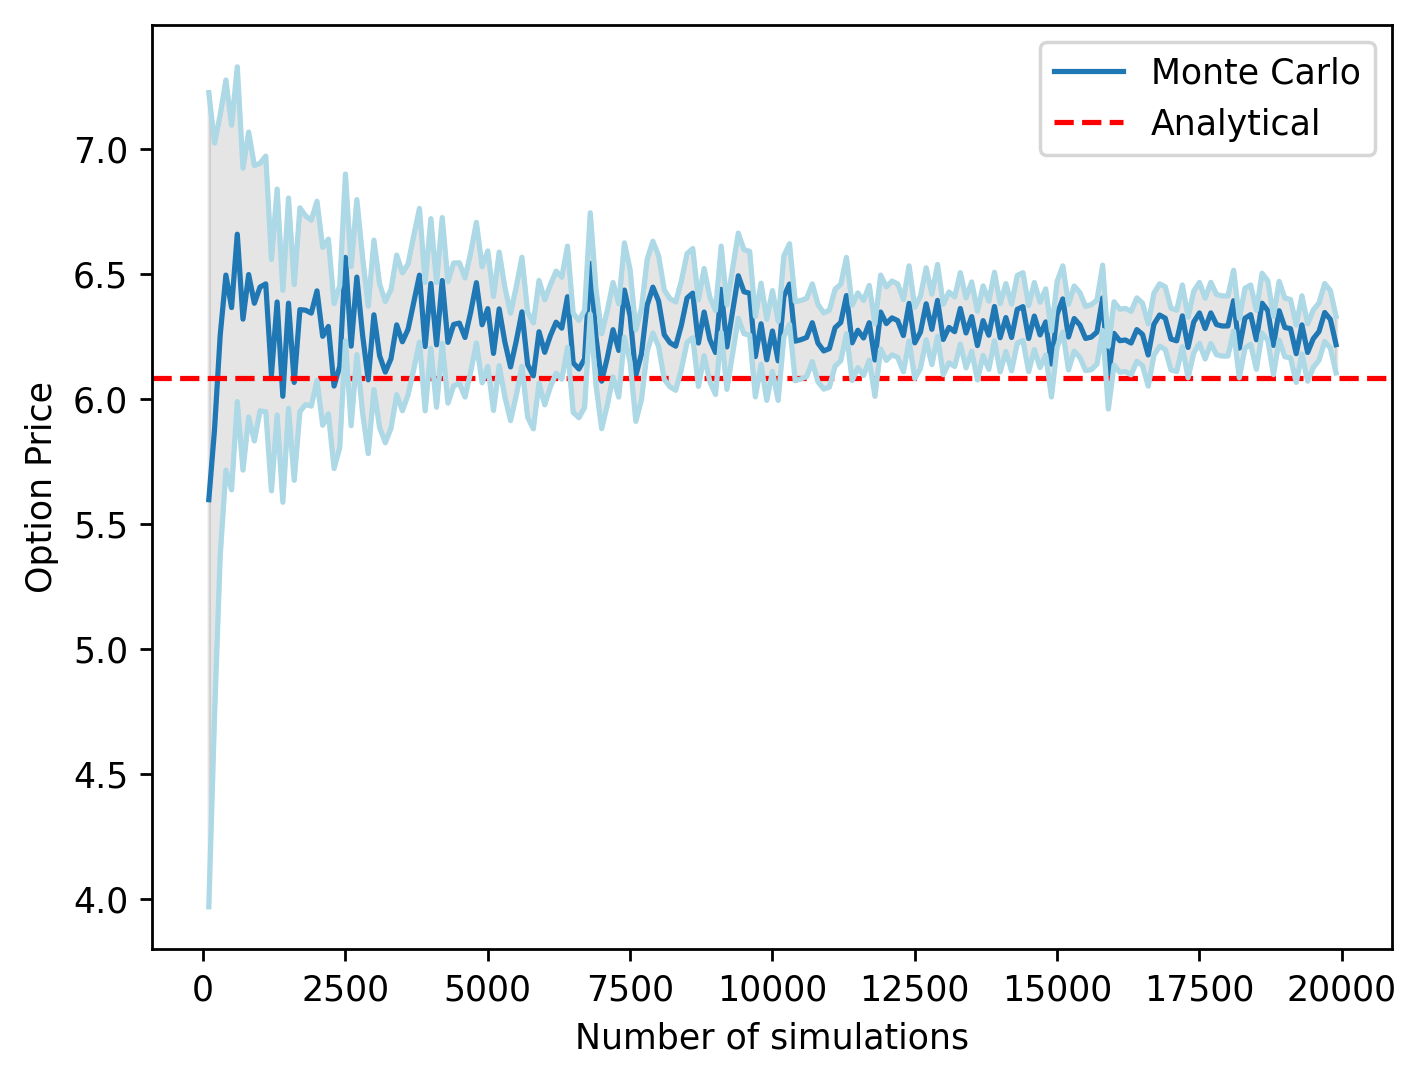

In [102]:
# Plotting the Monte Carlo Asian Option Prices
plt.figure(dpi=250)
plt.plot(no_of_simulations, MC_Asian_Option_prices, label = "Monte Carlo")
plt.axhline(Analytical_AsianOption_price, linestyle = "--", color = "red", label = "Analytical")
plt.plot(no_of_simulations, upper_bounds_Asian, color = "lightblue")
plt.plot(no_of_simulations, lower_bounds_Asian, color = "lightblue")
plt.fill_between(no_of_simulations, upper_bounds_Asian, lower_bounds_Asian, color="k", alpha=0.1)   
plt.xlabel("Number of simulations")
plt.ylabel("Option Price")
plt.legend()
plt.show()

### Control Variate

In [105]:
def function_G(stock_prices, strike_price):
    """
    Function to calculate the payoff for the lookback option
    
    Args:
        stock_prices : Stock prices
        strike_price : Strike price
    
    Returns:
        H : Payoff
    """
    G = max(geometric_mean(stock_prices) - strike_price, 0)
    
    return G

In [104]:
def expected_G(r, sigma, S0, K, T, N):
    
    sigma_tilda = sigma * np.sqrt((2*N + 1)/(6*(N + 1)))
    r_tilda = 0.5 * ((r - 0.5 * sigma **2) + sigma_tilda **2)
    d1 = (np.log(S0/K) + (r_tilda + 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(S0/K) + (r_tilda - 0.5 * sigma_tilda **2) * T)/(sigma_tilda * np.sqrt(T))
    
    expected_H = S0 * np.exp(r_tilda * T) * norm.cdf(d1) - K * norm.cdf(d2)    
    
    return expected_H
    

In [103]:
def calculateAsianOptionPrice_ControlVariate(riskfree_rate, S0, StrikeP, delta_t, T, vol_stockP, M, option_type = "call"):
    """
    Function to calculate the Asian option price using Monte Carlo method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        M : Number of simulations
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    N = int(T/delta_t)
    payOffs = np.zeros(M)
    g_y = np.zeros(M)
    expected_Gy = np.zeros(M)
    for i in range(M):
        stockPrices = euler_Method(S0, riskfree_rate, delta_t, N, vol_stockP)
        averagePrice = np.mean(stockPrices)
        g_y[i] = function_G(stockPrices, StrikeP)
        expected_Gy[i] = expected_G(riskfree_rate, vol_stockP, S0, StrikeP, T, N)
        
        if option_type == "call":
            payOffs[i] = max(averagePrice - StrikeP, 0)
        else:
            payOffs[i]= max(StrikeP - averagePrice, 0)
            
    covariance = np.cov(g_y, payOffs)[1, 0]
    var_g_y = np.var(g_y)  
    lambda1 = covariance/var_g_y
    
    Z = payOffs + lambda1 * (expected_Gy - g_y)
    return np.mean(Z), confidence_interval(Z)

In [106]:
optionPrice_control = []
CI_lower_control = []
CI_upper_control = []
#### Parameters
r = 0.05            # risk free rate
dt = 1/252          # time step
S0 = 100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 99             # strike price
m = np.arange(100, 20000, 100)
for M in tqdm(m):
    x, y = calculateAsianOptionPrice_ControlVariate(r, S0, K, dt, T, sigma, M)
    optionPrice_control.append(x)
    CI_lower_control.append(y[0])
    CI_upper_control.append(y[1])
    

100%|██████████| 199/199 [02:36<00:00,  1.27it/s]


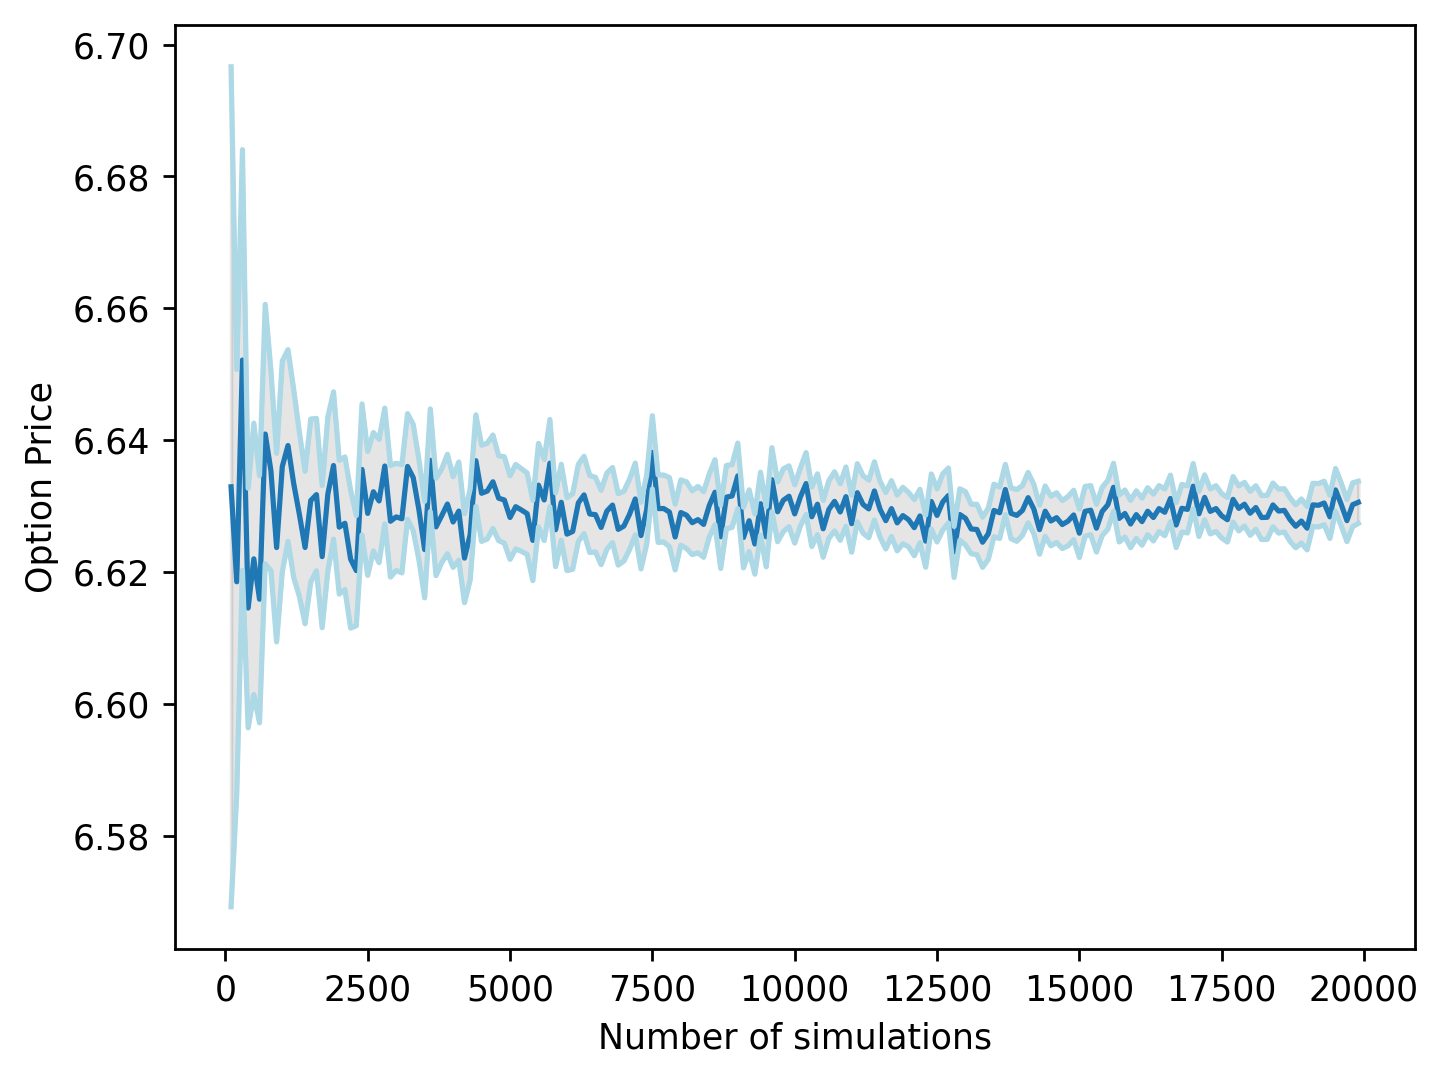

In [109]:
plt.figure(dpi=250)
plt.plot(m, optionPrice_control)
plt.plot(m, CI_upper_control, "lightblue")
plt.plot(m, CI_lower_control, "lightblue")
#plt.axhline(Analytical_AsianOption_price, linestyle = "--", color = "red", label = "Analytical")
plt.fill_between(m, CI_upper_control, CI_lower_control, color="k", alpha=0.1)
plt.xlabel("Number of simulations")
plt.ylabel("Option Price")
plt.show()